# Pattern Mining Phase: Matrix Profile Analysis

To validate the approximate motifs detected by SAX, a second high-precision pattern mining stage was conducted using the **Matrix Profile** method, implemented via the `stumpy` Python library. Unlike SAX, which relies on discretization, the Matrix Profile computes the exact Euclidean distances between all subsequences, offering a parameter-free method to identify motifs (repeating patterns) and discords (anomalies).

### Methodology
The Matrix Profile was computed for the Earthquake Time Series (E, N, and V channels) to locate the most conserved waveform shapes.

* **Algorithm:** We utilized `stumpy.stump`, a highly parallelized implementation of the exact motif discovery algorithm.
* **Window Size ($m$):** A window size of $m=1000,$ (approx. 10 second) was selected, consistent with the stable motif duration identified in the SAX analysis.
* **Metric:** **Z-normalized Euclidean Distance**. This normalization is critical for seismic analysis as it focuses on waveform *shape* rather than absolute *amplitude*, allowing the detection of repeating scattering patterns even as the earthquake signal attenuates over time.



### Analytical Objectives
The Matrix Profile vector $P$ was analyzed to extract two key physical features:

1.  **Motif Discovery (Global Minima):**
    The indices of the minimum values in $P$ correspond to the **Top-1 Motif**—the pair of subsequences with the highest similarity. This identifies the "signature" waveform of the site's crustal response.

2.  **Regime Change Detection (Semantic Segmentation):**
    By analyzing transitions in the Matrix Profile values, we identified boundaries between different physical regimes (e.g., the transition from the chaotic P-onset to the rhythmic, repeating Coda phase).

### Comparison with SAX Results
This stage serves as a verification step. While SAX provides a global statistical view of symbol distribution, `stumpy` provides exact localization.
* **Expectation:** If the SAX "P-coda motif" is real, the Matrix Profile should show a distinct "valley" (low distance values) in the region between P and S arrivals, indicating high self-similarity.
* **Discords:** High values in the Matrix Profile will highlight non-repeating transients, expected to correspond to the unique impulsive onsets of the P and S phases.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

signal_data = np.load("signal_data/processed_seismic_data.npy")

print(signal_data.shape)

(29871, 3, 1000)


In [3]:
metadata = pd.read_csv("metadata/processed_metadata.csv")

print(metadata.shape)

metadata.head()

(29871, 28)


,trace_name,network_code,receiver_code,receiver_type,source_origin_time,trace_start_time,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,...,source_magnitude,source_magnitude_type,source_distance_km,back_azimuth_deg,coda_end_sample,id,norm_s_arrival_sample,snr_db_E,snr_db_N,snr_db_V
0,109C.TA_20061103155652_EV,TA,109C,BH,2006-11-03 15:56:42.73,2006-11-03 15:56:53.610000,32.8889,-117.1051,150.0,600.0,...,4.3,mb,101.34,281.7,5508,235427,236,65.000000,65.500000,61.400002
1,109C.TA_20061129211102_EV,TA,109C,BH,2006-11-29 21:10:55.02,2006-11-29 21:11:03.890000,32.8889,-117.1051,150.0,900.0,...,4.1,ml,108.03,273.8,3199,235432,558,55.000000,56.099998,43.200001
2,109C.TA_20061129221547_EV,TA,109C,BH,2006-11-29 22:15:38.65,2006-11-29 22:15:48.630000,32.8889,-117.1051,150.0,800.0,...,3.9,ml,106.69,273.7,5252,235434,283,49.000000,48.000000,39.200001
3,109C.TA_20070209033349_EV,TA,109C,BH,2007-02-09 03:33:42.80,2007-02-09 03:33:50.600000,32.8889,-117.1051,150.0,900.0,...,4.2,ml,98.93,246.8,2866,235437,580,65.000000,68.199997,58.700001
4,109C.TA_20070415225732_EV,TA,109C,BH,2007-04-15 22:57:25.78,2007-04-15 22:57:33.940000,32.8889,-117.1051,150.0,900.0,...,4.3,ml,99.46,280.3,5848,235441,240,60.099998,64.800003,53.400002


In [4]:
print(metadata.columns)

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'source_origin_time', 'trace_start_time', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_travel_sec', 's_arrival_sample', 's_status', 'source_id',
       'source_latitude', 'source_longitude', 'source_depth_km',
       'source_magnitude', 'source_magnitude_type', 'source_distance_km',
       'back_azimuth_deg', 'coda_end_sample', 'id', 'norm_s_arrival_sample',
       'snr_db_E', 'snr_db_N', 'snr_db_V'],
      dtype='object')


In [5]:
metadata.columns

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'source_origin_time', 'trace_start_time', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_travel_sec', 's_arrival_sample', 's_status', 'source_id',
       'source_latitude', 'source_longitude', 'source_depth_km',
       'source_magnitude', 'source_magnitude_type', 'source_distance_km',
       'back_azimuth_deg', 'coda_end_sample', 'id', 'norm_s_arrival_sample',
       'snr_db_E', 'snr_db_N', 'snr_db_V'],
      dtype='object')

In [6]:
# quick monkeypatch workaround (temporary)
try:
    import numba.cuda.codegen as _ncg
    if not hasattr(_ncg.CUDACodeLibrary, "_reload_init"):
        # add a shared set so instance._reload_init.update(...) will work
        _ncg.CUDACodeLibrary._reload_init = set()
except Exception:
    # ignore if module not present yet / broken
    pass

# then import stumpy
import stumpy


In [ ]:
from stumpy import gpu_stump
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mine_motifs_gpu(signal_data, metadata, filters, m=100, top_n=5000):
    """
    Mines for motifs using NVIDIA GPU (1-Dimensional, East Channel).
    
    Parameters:
    - m: Window size (default 100 samples = 1 second)
    - top_n: Number of signals to process (RTX 3090 can handle 5000+ easily)
    """
    
    # --- STEP 1: FILTERING ---
    print(f"🔍 Filtering metadata...")
    df_subset = metadata.copy()
    for col, criteria in filters.items():
        if isinstance(criteria, tuple):
            df_subset = df_subset[(df_subset[col] >= criteria[0]) & (df_subset[col] <= criteria[1])]
        else:
            df_subset = df_subset[df_subset[col] == criteria]
    
    # Sort by SNR and limit count
    df_subset = df_subset.sort_values('snr_db_E', ascending=False).head(top_n)
    subset_indices = df_subset.index.to_numpy()
    print(f"   -> Processing {len(df_subset)} signals on RTX 3090 🚀")

    # --- STEP 2: DATA PREPARATION (NO PAA NEEDED) ---
    # We use FULL RESOLUTION because the GPU is powerful
    # Extract only East Channel (Index 0) for 1D analysis
    raw_waves = signal_data[subset_indices, 0, :]  # Shape: (N, 1000)
    
    # Create spacers (NaNs)
    spacers = np.full((len(df_subset), m), np.nan)
    
    # Concatenate: Signal -> Spacer -> Signal...
    combined = np.hstack([raw_waves, spacers])
    
    # Flatten to 1D array for GPU
    long_signal = combined.flatten().astype(np.float64) # GPU requires float64
    
    print(f"   -> Total Time Series Length: {len(long_signal):,} points")

    # --- STEP 3: RUN GPU STUMP ---
    print(f"⚙️ Running GPU Matrix Profile (m={m})...")
    
    # Using gpu_stump (1D)
    mp = gpu_stump(long_signal, m=m)
    
    # --- STEP 4: EXTRACT RESULTS ---
    # Column 0 = Distance, Column 1 = Nearest Neighbor Index
    best_idx = np.argmin(mp[:, 0])
    nearest_idx = int(mp[best_idx, 1])
    min_dist = mp[best_idx, 0]
    
    # Map back to original trace ID
    def get_trace_location(flat_idx, signal_len, spacer_len):
        total_block = signal_len + spacer_len
        trace_id = flat_idx // total_block
        offset = flat_idx % total_block
        return trace_id, offset

    trace_a, start_a = get_trace_location(best_idx, 1000, m)
    trace_b, start_b = get_trace_location(nearest_idx, 1000, m)
    
    print(f"✅ GPU Pattern Found! Distance: {min_dist:.4f}")
    print(f"   Trace #{trace_a} matches Trace #{trace_b}")

    # --- VISUALIZATION ---
    plt.figure(figsize=(10, 4))
    
    # Extract waveforms
    wave_a = signal_data[subset_indices[trace_a], 0, :]
    wave_b = signal_data[subset_indices[trace_b], 0, :]
    
    # Plot Context (Grey)
    plt.plot(wave_a, color='lightgrey', alpha=0.5, label='Trace A Context')
    
    # Plot Motifs (Red/Blue)
    motif_a = wave_a[start_a : start_a + m]
    motif_b = wave_b[start_b : start_b + m]
    
    plt.plot(np.arange(start_a, start_a+m), motif_a, color='tab:red', lw=2, label='Motif A')
    plt.plot(np.arange(start_b, start_b+m), motif_b, color='tab:blue', ls='--', lw=2, label='Motif B')
    
    plt.title(f"RTX 3090 Discovery (East Channel Only, m={m})\nMatched Pattern Across Earthquakes")
    plt.xlabel("Time (Samples)")
    plt.ylabel("East Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_subset

🔍 Filtering metadata...
   -> Processing 1000 signals on RTX 3090 🚀
   -> Total Time Series Length: 1,100,000 points
⚙️ Running GPU Matrix Profile (m=100)...
✅ GPU Pattern Found! Distance: 0.0000
   Trace #453 matches Trace #557


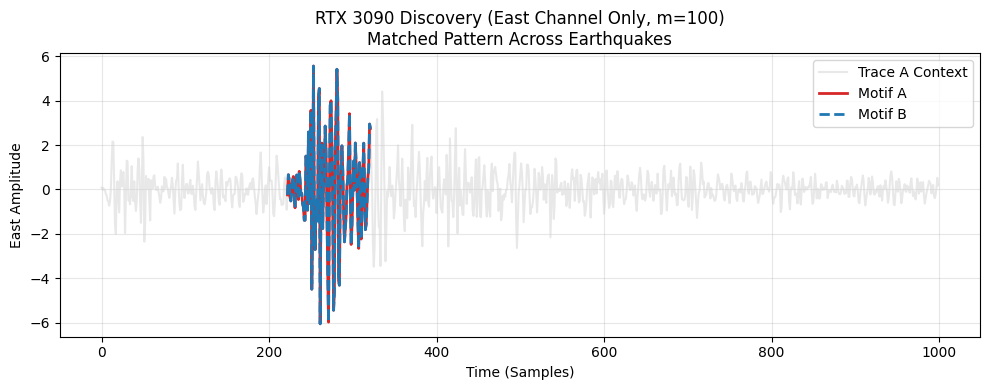

,trace_name,network_code,receiver_code,receiver_type,source_origin_time,trace_start_time,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,...,source_magnitude,source_magnitude_type,source_distance_km,back_azimuth_deg,coda_end_sample,id,norm_s_arrival_sample,snr_db_E,snr_db_N,snr_db_V
4487,BLA2.CI_20160610080445_EV,CI,BLA2,HH,2016-06-10 08:04:38.700000,2016-06-10 08:04:45.600000,34.06931,-116.38993,1247.0,500.0,...,5.2,mw,70.78,183.900,2473,557137,435,100.000000,103.599998,95.699997
16576,M12A.TA_20080401131616_EV,TA,M12A,BH,2008-04-01 13:16:18.20,2008-04-01 13:16:17.550000,41.41570,-114.91510,1930.0,400.0,...,4.3,mb,26.35,345.300,2096,936160,191,99.900002,95.199997,74.699997
24154,SHP.NN_20150522184749_EV,NN,SHP,HH,2015-05-22 18:47:42.980000,2015-05-22 18:47:49.521390,36.50470,-115.15670,1632.0,900.0,...,5.3,ml,98.12,27.160,3319,1143675,551,99.800003,99.900002,96.699997
17724,MONP2.AZ_20160610080442_EV,AZ,MONP2,HH,2016-06-10 08:04:38.700000,2016-06-10 08:04:42.000000,32.89200,-116.42230,1875.0,700.0,...,5.2,mw,59.75,358.200,2347,971631,457,99.699997,101.000000,102.300003
27180,TRF.AK_20110123025000_EV,AK,TRF,BH,2011-01-23 02:50:05.52,2011-01-23 02:50:01.360000,63.45020,-150.28930,1711.9,900.0,...,5.2,mw,27.50,104.200,5900,1199380,81,99.699997,92.300003,91.400002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13463,ITM.HL_20080106051430_EV,HL,ITM,SH,2008-01-06 05:14:21.03,2008-01-06 05:14:31.800000,37.17872,21.92522,423.0,400.0,...,6.2,mw,69.64,263.100,5400,849980,242,82.400002,99.400002,87.800003
29222,WAT2.AK_20140924073116_EV,AK,WAT2,BH,2014-09-24 07:30:56.15,2014-09-24 07:31:17.890000,62.96280,-148.58550,1366.0,800.0,...,4.5,mb,203.42,332.400,5900,1233519,465,82.300003,76.099998,75.199997
17762,MPI.CI_20150104031811_EV,CI,MPI,HH,2015-01-04 03:18:09.62,2015-01-04 03:18:12.140000,34.81258,-119.14530,2673.0,600.0,...,4.2,mb,52.82,295.600,3397,972478,228,82.300003,83.400002,76.400002
1419,AMKA.AV_20140624151513_EV,AV,AMKA,BH,2014-06-24 15:15:04.330000,2014-06-24 15:15:13.240000,51.37710,179.30000,116.0,1000.0,...,4.6,mb,79.99,311.632,3282,261209,582,82.300003,81.900002,72.400002


In [17]:
filters = {
    'snr_db_E': (15, 100)
}


mine_motifs_gpu(signal_data,metadata,filters,m=100, top_n=1000)

In [19]:
import stumpy
from stumpy import gpu_stump
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress Numba and STUMPY initialization warnings
warnings.filterwarnings("ignore")

def mine_motifs_gpu_full(signal_data, metadata, filters, m=100, top_n=1000, cutoff=15.0):
    """
    Complete GPU-accelerated motif mining for seismic data.
    
    Returns:
    - df_subset: The filtered metadata used for the search.
    """
    
    # --- 1. FILTERING & SELECTION ---
    print(f"🔍 Filtering signals...")
    df_subset = metadata.copy()
    for col, criteria in filters.items():
        if isinstance(criteria, tuple):
            df_subset = df_subset[(df_subset[col] >= criteria[0]) & (df_subset[col] <= criteria[1])]
        else:
            df_subset = df_subset[df_subset[col] == criteria]
    
    # Sort and limit
    df_subset = df_subset.sort_values('snr_db_E', ascending=False).head(top_n)
    subset_indices = df_subset.index.to_numpy()
    
    if len(subset_indices) < 2:
        print("❌ Not enough signals found after filtering. Lower your SNR requirements.")
        return df_subset

    # --- 2. DATA PREPARATION ---
    # Extracting East Channel (Index 0)
    raw_waves = signal_data[subset_indices, 0, :]  # Shape: (N, 1000)
    sig_len = raw_waves.shape[1]
    
    # Create spacers to prevent motifs from crossing between signals
    spacers = np.full((len(subset_indices), m), np.nan)
    combined = np.hstack([raw_waves, spacers])
    long_signal = combined.flatten().astype(np.float64) 
    
    print(f"🚀 Processing {len(subset_indices)} signals ({len(long_signal):,} points) on GPU...")

    # --- 3. MATRIX PROFILE CALCULATION ---
    mp = gpu_stump(long_signal, m=m)

    # --- 4. HELPER FUNCTION ---
    def get_trace_info(flat_idx):
        """Calculates which trace and where inside that trace a flat index belongs."""
        total_block = sig_len + m
        trace_idx = int(flat_idx // total_block)
        offset = int(flat_idx % total_block)
        return trace_idx, offset

    # --- 5. MOTIF EXTRACTION ---
    # Find the top recurring patterns
    motif_distances, motif_indices = stumpy.motifs(
        long_signal, 
        mp[:, 0], 
        max_matches=10, 
        cutoff=cutoff
    )

    if len(motif_indices) == 0:
        print(f"⚠️ No motifs found with cutoff {cutoff}. Try increasing cutoff or decreasing 'm'.")
        return df_subset

    # --- 6. VISUALIZATION: BEST MOTIF IN CONTEXT ---
    # We take the top motif (Index 0)
    best_motif_set = motif_indices[0]
    best_motif_set = best_motif_set[best_motif_set >= 0] # Remove placeholders
    
    if len(best_motif_set) >= 2:
        print(f"✅ Found Motif Type #1 with {len(best_motif_set)} occurrences.")
        
        # Get IDs for the first two occurrences
        t1, s1 = get_trace_info(best_motif_set[0])
        t2, s2 = get_trace_info(best_motif_set[1])
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

        # Subplot 1: Context Trace A
        wave_a = signal_data[subset_indices[t1], 0, :]
        ax1.plot(wave_a, color='lightgrey', label='Full Waveform A')
        ax1.plot(np.arange(s1, s1+m), wave_a[s1:s1+m], color='tab:red', lw=2, label='Motif A Location')
        ax1.set_title(f"Occurrence A (Trace {subset_indices[t1]})")
        ax1.legend()

        # Subplot 2: Context Trace B
        wave_b = signal_data[subset_indices[t2], 0, :]
        ax2.plot(wave_b, color='lightgrey', label='Full Waveform B')
        ax2.plot(np.arange(s2, s2+m), wave_b[s2:s2+m], color='tab:blue', lw=2, label='Motif B Location')
        ax2.set_title(f"Occurrence B (Trace {subset_indices[t2]})")
        ax2.legend()

        # Subplot 3: Overlaid Comparison (The "Shape" Match)
        ax3.plot(wave_a[s1:s1+m], color='tab:red', label='Motif A (Zoomed)', alpha=0.8)
        ax3.plot(wave_b[s2:s2+m], color='tab:blue', ls='--', label='Motif B (Zoomed)', alpha=0.8)
        ax3.set_title("Direct Shape Comparison (Similarity Check)")
        ax3.legend()

        plt.tight_layout()
        plt.show()
    
    return df_subset

# --- EXAMPLE USAGE ---
# filters = {'snr_db_E': (20, 100)}
# df = mine_motifs_gpu_full(signal_data, metadata, filters, m=100)

🔍 Filtering signals...
🚀 Processing 80 signals (88,000 points) on GPU...
✅ Found Motif Type #1 with 10 occurrences.


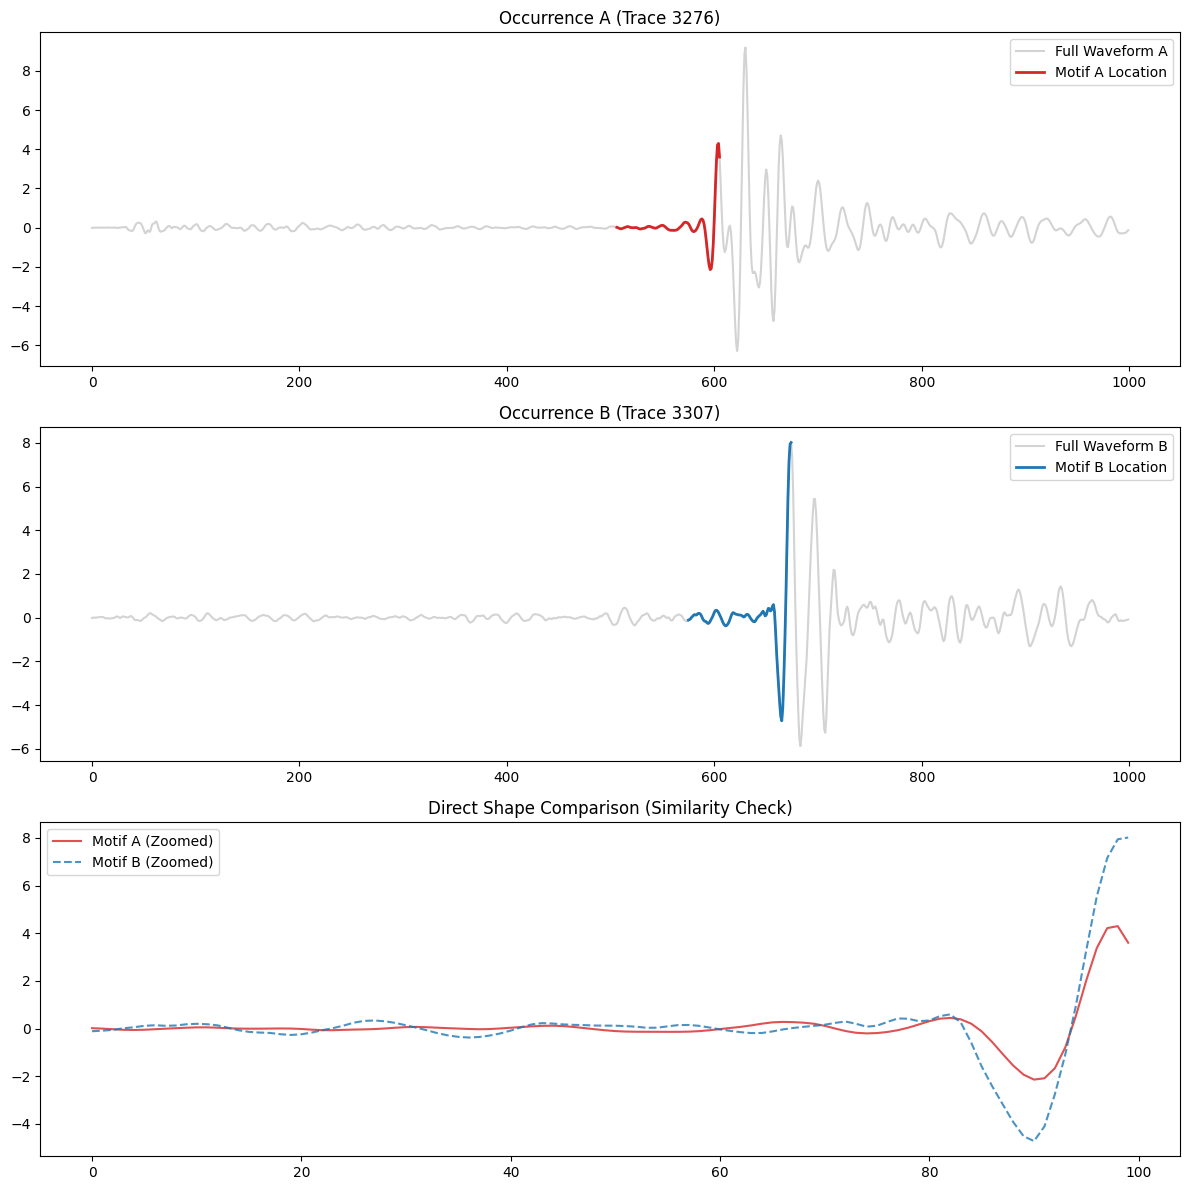

,trace_name,network_code,receiver_code,receiver_type,source_origin_time,trace_start_time,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,...,source_magnitude,source_magnitude_type,source_distance_km,back_azimuth_deg,coda_end_sample,id,norm_s_arrival_sample,snr_db_E,snr_db_N,snr_db_V
4487,BLA2.CI_20160610080445_EV,CI,BLA2,HH,2016-06-10 08:04:38.700000,2016-06-10 08:04:45.600000,34.06931,-116.38993,1247.0,500.0,...,5.2,mw,70.78,183.900,2473,557137,435,100.000000,103.599998,95.699997
16576,M12A.TA_20080401131616_EV,TA,M12A,BH,2008-04-01 13:16:18.20,2008-04-01 13:16:17.550000,41.41570,-114.91510,1930.0,400.0,...,4.3,mb,26.35,345.300,2096,936160,191,99.900002,95.199997,74.699997
24154,SHP.NN_20150522184749_EV,NN,SHP,HH,2015-05-22 18:47:42.980000,2015-05-22 18:47:49.521390,36.50470,-115.15670,1632.0,900.0,...,5.3,ml,98.12,27.160,3319,1143675,551,99.800003,99.900002,96.699997
17724,MONP2.AZ_20160610080442_EV,AZ,MONP2,HH,2016-06-10 08:04:38.700000,2016-06-10 08:04:42.000000,32.89200,-116.42230,1875.0,700.0,...,5.2,mw,59.75,358.200,2347,971631,457,99.699997,101.000000,102.300003
27180,TRF.AK_20110123025000_EV,AK,TRF,BH,2011-01-23 02:50:05.52,2011-01-23 02:50:01.360000,63.45020,-150.28930,1711.9,900.0,...,5.2,mw,27.50,104.200,5900,1199380,81,99.699997,92.300003,91.400002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13345,ISA.CI_20130825185026_EV,CI,ISA,HH,2013-08-25 18:50:28.21,2013-08-25 18:50:27.950000,35.66278,-118.47403,873.0,500.0,...,4.1,mwr,31.30,309.700,2536,848242,188,95.199997,89.500000,92.900002
11885,GRNC.AK_20140717114937_EV,AK,GRNC,BH,2014-07-17 11:49:33.000000,2014-07-17 11:49:37.970000,60.73150,-141.75580,2116.0,1000.0,...,6.0,mb,91.58,122.309,4548,818247,339,95.199997,98.800003,97.400002
130,AC04.C1_20150224042854_EV,C1,AC04,HH,2015-02-24 04:28:50.97,2015-02-24 04:28:55.730000,-28.20460,-71.07390,249.0,800.0,...,4.4,mb,66.55,134.500,5900,240269,137,95.099998,96.800003,96.300003
13803,KABU.AV_20130310171120_EV,AV,KABU,BH,2013-03-10 17:11:05.22,2013-03-10 17:11:21.060000,58.27020,-155.28430,1065.0,600.0,...,5.2,mw,130.23,212.500,5900,859815,293,95.099998,94.699997,66.800003


In [36]:
filters = {
    'snr_db_E': (15, 100)
}


mine_motifs_gpu_full(signal_data,metadata_unique,filters,m=100, top_n=80, cutoff=5.0)

In [22]:
# Check the metadata for the two traces in the plot
match_info = metadata.loc[[14974, 14975]]
print(match_info)

                     trace_name network_code receiver_code receiver_type  \
14974  KHZ.NZ_20150424033645_EV           NZ           KHZ            HH   
14975  KHZ.NZ_20150424033646_EV           NZ           KHZ            HH   

           source_origin_time            trace_start_time  receiver_latitude  \
14974  2015-04-24 03:36:42.21  2015-04-24 03:36:46.660000          -42.41598   
14975  2015-04-24 03:36:42.21  2015-04-24 03:36:47.660000          -42.41598   

       receiver_longitude  receiver_elevation_m  p_arrival_sample  ...  \
14974           173.53897                  64.0             700.0  ...   
14975           173.53897                  64.0             600.0  ...   

      source_magnitude  source_magnitude_type  source_distance_km  \
14974              6.0                     mw                49.6   
14975              6.0                     mw                49.6   

      back_azimuth_deg coda_end_sample      id  norm_s_arrival_sample  \
14974            134.3    

In [23]:
metadata.columns

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'source_origin_time', 'trace_start_time', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_travel_sec', 's_arrival_sample', 's_status', 'source_id',
       'source_latitude', 'source_longitude', 'source_depth_km',
       'source_magnitude', 'source_magnitude_type', 'source_distance_km',
       'back_azimuth_deg', 'coda_end_sample', 'id', 'norm_s_arrival_sample',
       'snr_db_E', 'snr_db_N', 'snr_db_V'],
      dtype='object')

In [ ]:
# Identify unique earthquake recordings per station
metadata_unique = metadata.drop_duplicates(
    subset=['source_magnitude', 'source_distance_km', 'back_azimuth_deg', 'source_longitude', 'source_latitude'], 
    keep='first'
)

print(f"Removed {len(metadata) - len(metadata_unique)} duplicate windows.")

Removed 4367 duplicate windows.


In [25]:
metadata_unique.shape

(25496, 28)

In [37]:
import stumpy
from stumpy import gpu_stump
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress technical noise
warnings.filterwarnings("ignore")

def mine_motifs_gpu_advanced(signal_data, metadata, filters, 
                             m=100, 
                             top_n=1000, 
                             cutoff=15.0, 
                             channel_idx=0, 
                             n_random=None):
    """
    Advanced GPU Motif Mining with deduplication, sampling, and channel selection.
    
    Parameters:
    - channel_idx: 0 (East), 1 (North), 2 (Vertical)
    - n_random: If set, will take a random sample of N signals instead of top SNR.
    """
    
    channel_map = {0: "East", 1: "North", 2: "Vertical"}
    current_channel = channel_map.get(channel_idx, "Unknown")
    
    # --- 1. FILTERING & DEDUPLICATION ---
    print(f"🔍 Filtering metadata for channel: {current_channel}")
    df_subset = metadata.copy()
    for col, criteria in filters.items():
        if isinstance(criteria, tuple):
            df_subset = df_subset[(df_subset[col] >= criteria[0]) & (df_subset[col] <= criteria[1])]
        else:
            df_subset = df_subset[df_subset[col] == criteria]
    
    # CRITICAL: Remove same-event duplicates discovered in previous step
    # We keep the one with the highest SNR
    df_subset = df_subset.sort_values('snr_db_E', ascending=False)
    df_subset = df_subset.drop_duplicates(subset=['source_origin_time', 'receiver_code'], keep='first')
    
    # --- 2. SAMPLING LOGIC ---
    if n_random and n_random < len(df_subset):
        print(f"🎲 Sampling {n_random} random unique signals...")
        df_subset = df_subset.sample(n=n_random)
    else:
        print(f"🔝 Selecting top {top_n} signals by SNR...")
        df_subset = df_subset.head(top_n)
        
    subset_indices = df_subset.index.to_numpy()
    
    if len(subset_indices) < 2:
        print("❌ Not enough unique signals found.")
        return df_subset

    # --- 3. DATA PREPARATION ---
    # Use channel_idx for the second dimension
    raw_waves = signal_data[subset_indices, channel_idx, :]  
    sig_len = raw_waves.shape[1]
    
    spacers = np.full((len(subset_indices), m), np.nan)
    combined = np.hstack([raw_waves, spacers])
    long_signal = combined.flatten().astype(np.float64) 
    
    print(f"🚀 Processing {len(subset_indices)} unique records on GPU...")

    # --- 4. GPU CALCULATION ---
    mp = gpu_stump(long_signal, m=m)

    # --- 5. EXTRACTION & VISUALIZATION ---
    def get_trace_info(flat_idx):
        total_block = sig_len + m
        trace_idx = int(flat_idx // total_block)
        offset = int(flat_idx % total_block)
        return trace_idx, offset

    motif_distances, motif_indices = stumpy.motifs(long_signal, mp[:, 0], max_matches=10, cutoff=cutoff)

    if len(motif_indices) > 0:
        best_motif_set = motif_indices[0][motif_indices[0] >= 0]
        if len(best_motif_set) >= 2:
            t1, s1 = get_trace_info(best_motif_set[0])
            t2, s2 = get_trace_info(best_motif_set[1])
            
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
            
            # Setup Plot Labels
            title_suffix = f"(Channel: {current_channel}, m={m})"
            
            # Plot Trace A
            w_a = signal_data[subset_indices[t1], channel_idx, :]
            ax1.plot(w_a, color='lightgrey')
            ax1.plot(np.arange(s1, s1+m), w_a[s1:s1+m], color='tab:red', lw=2)
            ax1.set_title(f"Event A: {df_subset.iloc[t1]['trace_name']} {title_suffix}")

            # Plot Trace B
            w_b = signal_data[subset_indices[t2], channel_idx, :]
            ax2.plot(w_b, color='lightgrey')
            ax2.plot(np.arange(s2, s2+m), w_b[s2:s2+m], color='tab:blue', lw=2)
            ax2.set_title(f"Event B: {df_subset.iloc[t2]['trace_name']}")

            # Overlay
            ax3.plot(w_a[s1:s1+m], color='tab:red', label='Motif A', alpha=0.7)
            ax3.plot(w_b[s2:s2+m], color='tab:blue', ls='--', label='Motif B', alpha=0.7)
            ax3.legend()
            ax3.set_title("Direct Comparison (Z-Normalized Shape)")

            plt.tight_layout()
            plt.show()
            
            print(f"✨ Found match between different origin times!")
            print(f"   Time A: {df_subset.iloc[t1]['source_origin_time']}")
            print(f"   Time B: {df_subset.iloc[t2]['source_origin_time']}")
    
    return df_subset

🔍 Filtering metadata for channel: East
🎲 Sampling 500 random unique signals...
🚀 Processing 500 unique records on GPU...


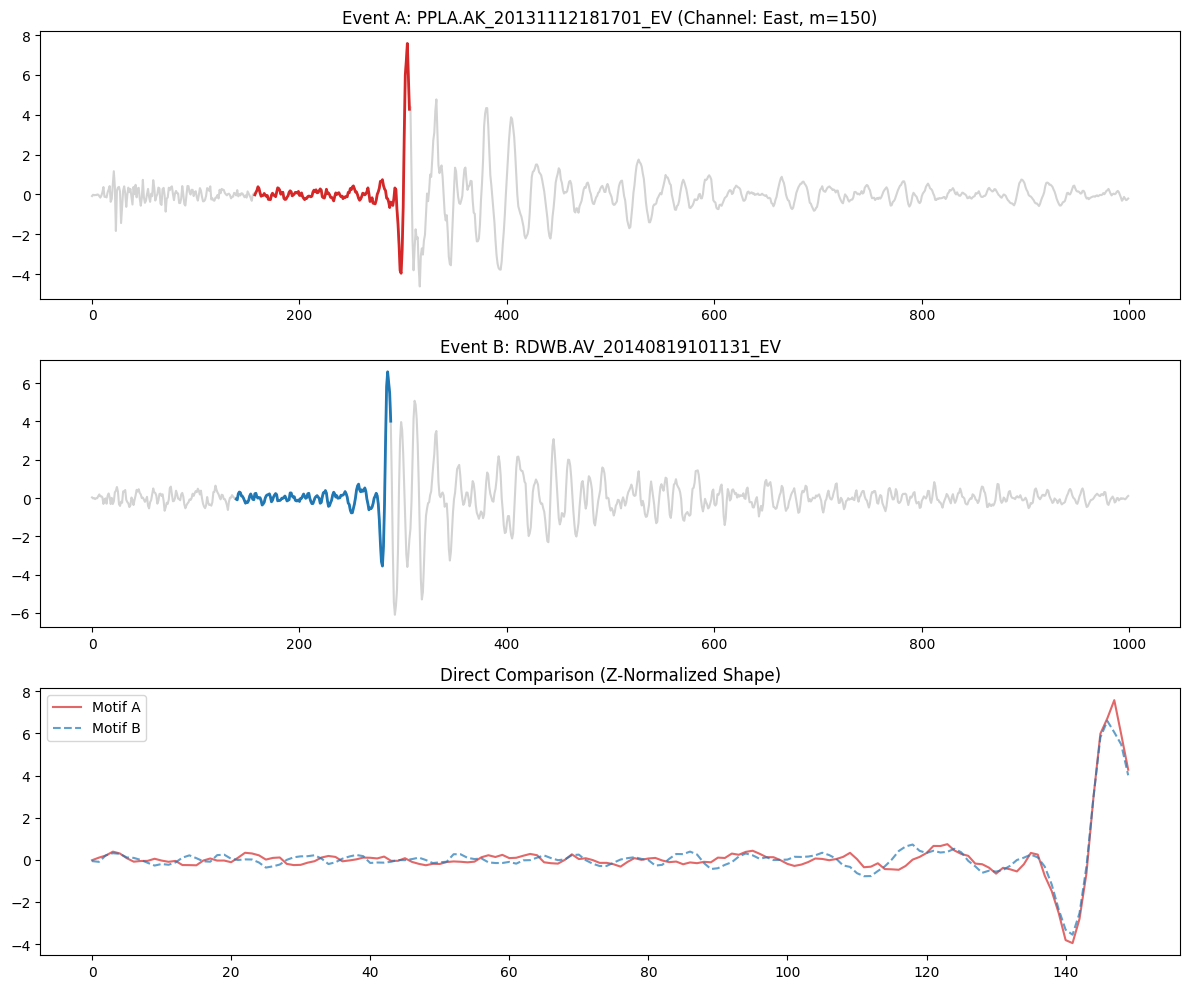

✨ Found match between different origin times!
   Time A: 2013-11-12 18:16:48.21
   Time B: 2014-08-19 10:11:22.17


In [38]:
# Search for random matches on the Vertical channel (idx 2)
filters = {'snr_db_V': (15, 100)}

df_results = mine_motifs_gpu_advanced(
    signal_data, 
    metadata, 
    filters, 
    channel_idx=0,   # Use Vertical channel
    n_random=500,   # Pick 1000 signals at random
    m=150            # Slightly longer window
)

In [ ]:
def extract_all_motifs(signal_data, metadata, filters, m=100, top_n=1000, channel_idx=0, n_random=None, cutoff=15.0):
    # --- [Standard Filtering & Prep Code - Same as before] ---
    df_subset = metadata.copy()
    for col, criteria in filters.items():
        if isinstance(criteria, tuple):
            df_subset = df_subset[(df_subset[col] >= criteria[0]) & (df_subset[col] <= criteria[1])]
        else:
            df_subset = df_subset[df_subset[col] == criteria]
    
    df_subset = df_subset.sort_values('snr_db_E', ascending=False).drop_duplicates(subset=['source_origin_time', 'receiver_code'], keep='first')
    
    if n_random:
        df_subset = df_subset.sample(n=min(n_random, len(df_subset)))
    else:
        df_subset = df_subset.head(top_n)
        
    subset_indices = df_subset.index.to_numpy()
    raw_waves = signal_data[subset_indices, channel_idx, :]
    sig_len = raw_waves.shape[1]
    
    spacers = np.full((len(subset_indices), m), np.nan)
    long_signal = np.hstack([raw_waves, spacers]).flatten().astype(np.float64)
    mp = gpu_stump(long_signal, m=m)
    
    motif_distances, motif_indices = stumpy.motifs(long_signal, mp[:, 0], max_matches=50, cutoff=cutoff)
    
    extracted_segments = []
    segment_metadata = []

    def get_trace_info(flat_idx):
        total_block = sig_len + m
        return int(flat_idx // total_block), int(flat_idx % total_block)
    
    extracted_segments = []
    segment_metadata = []

    for group_idx, occurrences in enumerate(motif_indices):
        valid_indices = occurrences[occurrences >= 0]
        for flat_idx in valid_indices:
            t_idx, start = get_trace_info(flat_idx) # Helper function from before
            seg = raw_waves[t_idx, start : start + m]
            
            if len(seg) == m and not np.isnan(seg).any():
                z_seg = (seg - np.mean(seg)) / np.std(seg)
                extracted_segments.append(z_seg)
                
                # ✨ Store the location pointers
                meta = df_subset.iloc[t_idx].to_dict()
                meta['subset_t_idx'] = t_idx  # Index within the processed batch
                meta['start_offset'] = start   # Where the motif begins
                segment_metadata.append(meta)

    return np.array(extracted_segments), pd.DataFrame(segment_metadata), subset_indices

    for group_idx, occurrences in enumerate(motif_indices):
        valid_indices = occurrences[occurrences >= 0]
        for flat_idx in valid_indices:
            t_idx, start = get_trace_info(flat_idx)
            seg = raw_waves[t_idx, start : start + m]
            
            # ✨ CRITICAL FIX: Only keep segments that have NO NaNs and correct length
            if len(seg) == m and not np.isnan(seg).any():
                # Z-normalize for clustering
                z_seg = (seg - np.mean(seg)) / np.std(seg)
                extracted_segments.append(z_seg)
                
                meta = df_subset.iloc[t_idx].to_dict()
                meta['motif_group_id'] = group_idx
                segment_metadata.append(meta)

    return np.array(extracted_segments), pd.DataFrame(segment_metadata)

In [74]:
import stumpy
from stumpy import gpu_stump
import numpy as np
import pandas as pd
import warnings

# Suppress technical warnings
warnings.filterwarnings("ignore")

def mine_and_extract_motifs(signal_data, metadata, filters, m=100, top_n=1000, 
                            channel_idx=0, n_random=None, cutoff=15.0):
    """
    GPU-accelerated mining and motif extraction.
    Returns segments, metadata, matrix profile, and indices.
    """
    # --- STEP 1: FILTERING & DEDUPLICATION ---
    print("🔍 Cleaning and filtering metadata...")
    df_subset = metadata.copy()
    for col, criteria in filters.items():
        if isinstance(criteria, tuple):
            df_subset = df_subset[(df_subset[col] >= criteria[0]) & (df_subset[col] <= criteria[1])]
        else:
            df_subset = df_subset[df_subset[col] == criteria]
    
    # Remove same-event duplicates (same time/station)
    df_subset = df_subset.sort_values('snr_db_E', ascending=False)
    df_subset = df_subset.drop_duplicates(subset=['source_origin_time', 'receiver_code'], keep='first')
    
    # Sampling logic
    if n_random:
        df_subset = df_subset.sample(n=min(n_random, len(df_subset)))
    else:
        df_subset = df_subset.head(top_n)
        
    subset_indices = df_subset.index.to_numpy()
    raw_waves = signal_data[subset_indices, channel_idx, :]
    sig_len = raw_waves.shape[1]
    
    # --- STEP 2: GPU MATRIX PROFILE ---
    # We add spacers to prevent motifs from crossing between signals
    spacers = np.full((len(subset_indices), m), np.nan)
    long_signal = np.hstack([raw_waves, spacers]).flatten().astype(np.float64)
    
    print(f"🚀 Running GPU Matrix Profile on {len(subset_indices)} unique traces...")
    mp = gpu_stump(long_signal, m=m)
    
    # --- STEP 3: MOTIF EXTRACTION ---
    print(f"✨ Extracting motif segments (Cutoff: {cutoff})...")
    # Finding recurring patterns in the distance profile
    motif_distances, motif_indices = stumpy.motifs(long_signal, mp[:, 0], max_matches=50, cutoff=cutoff)
    
    extracted_segments = []
    segment_metadata = []

    def get_trace_info(flat_idx):
        total_block = sig_len + m
        return int(flat_idx // total_block), int(flat_idx % total_block)

    for group_idx, occurrences in enumerate(motif_indices):
        valid_indices = occurrences[occurrences >= 0]
        for flat_idx in valid_indices:
            t_idx, start = get_trace_info(flat_idx)
            
            # Slice the segment from raw waves
            seg = raw_waves[t_idx, start : start + m]
            
            # 🛑 CRITICAL SAFETY CHECKS
            # 1. Must be exact window length
            # 2. Must NOT contain any NaNs from the spacers
            if len(seg) == m and not np.isnan(seg).any():
                # Z-normalize for valid comparison/clustering
                z_seg = (seg - np.mean(seg)) / np.std(seg)
                extracted_segments.append(z_seg)
                
                # Enrich metadata for this specific match
                meta = df_subset.iloc[t_idx].to_dict()
                meta['motif_group_id'] = group_idx
                meta['start_offset'] = start
                meta['subset_t_idx'] = t_idx
                segment_metadata.append(meta)

    print(f"✅ Finished! Found {len(extracted_segments)} valid motif segments.")
    return np.array(extracted_segments), pd.DataFrame(segment_metadata), mp, subset_indices

In [75]:
import stumpy
from stumpy import gpu_stump
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

def cluster_and_plot_motifs(segments, meta_df, n_clusters=3):
    if len(segments) < n_clusters:
        print("Not enough motifs found to cluster. Try increasing 'cutoff' in the miner.")
        return
    
    # Perform Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(segments)
    meta_df['cluster_label'] = clusters

    # Visualization
    fig, axs = plt.subplots(n_clusters, 1, figsize=(10, 3 * n_clusters), sharex=True)
    if n_clusters == 1: axs = [axs]

    for i in range(n_clusters):
        cluster_segments = segments[clusters == i]
        
        # Plot all members of the cluster in light alpha
        for seg in cluster_segments:
            axs[i].plot(seg, color='gray', alpha=0.2)
        
        # Plot the Centroid (The "Average" Pattern)
        centroid = kmeans.cluster_centers_[i]
        axs[i].plot(centroid, color='red', lw=2, label='Cluster Centroid')
        
        axs[i].set_title(f"Pattern Cluster #{i+1} ({len(cluster_segments)} signals)")
        axs[i].grid(True, alpha=0.3)
        axs[i].legend()

    plt.xlabel("Samples")
    plt.tight_layout()
    plt.show()
    
    return meta_df

In [76]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def cluster_and_visualize_pca_3d(segments, meta_df, n_clusters=3):
    # 1. Safety Checks
    if segments.size == 0:
        print("❌ No valid segments found.")
        return None, None

    mask = ~np.isnan(segments).any(axis=1)
    segments = segments[mask]
    meta_df = meta_df.iloc[mask].reset_index(drop=True)

    if len(segments) < n_clusters:
        print(f"❌ Found only {len(segments)} valid segments, but asked for {n_clusters} clusters.")
        return None, None

    # 2. Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(segments)
    meta_df['cluster_label'] = clusters

    # 3. PCA (3 Components)
    pca = PCA(n_components=3)
    pca_results = pca.fit_transform(segments)
    var_exp = pca.explained_variance_ratio_ * 100

    # --- 4. VISUALIZATION ---
    fig = plt.figure(figsize=(16, 7))

    # --- Subplot 1: 2D View ---
    ax1 = fig.add_subplot(121)
    scatter1 = ax1.scatter(pca_results[:, 0], pca_results[:, 1], 
                           c=clusters, cmap='viridis', alpha=0.6, s=40)
    ax1.set_title(f'2D PCA Projection\n(Var: {var_exp[0]:.1f}% + {var_exp[1]:.1f}%)')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.grid(True, alpha=0.2)

    # --- Subplot 2: 3D View ---
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(pca_results[:, 0], pca_results[:, 1], pca_results[:, 2], 
                           c=clusters, cmap='viridis', alpha=0.7, s=50, edgecolors='w')
    
    ax2.set_title(f'3D PCA Projection\n(Total Var: {sum(var_exp):.1f}%)')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('PC3')
    
    # Add a unified colorbar
    plt.colorbar(scatter1, ax=[ax1, ax2], label='Cluster ID', shrink=0.6)
    
    plt.show()

    return meta_df, pca

In [77]:
def cluster_and_plot_full_sequences(segments, meta_df, signal_data, subset_indices, 
                                    n_clusters=3, channel_idx=0, m=100):
    # 1. Perform Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(segments)
    meta_df['cluster_label'] = clusters

    # 2. Visualization
    fig, axs = plt.subplots(n_clusters, 1, figsize=(12, 4 * n_clusters), sharex=True)
    if n_clusters == 1: axs = [axs]

    # Use a color palette for different clusters
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_meta = meta_df[meta_df['cluster_label'] == i]
        ax = axs[i]
        
        # Limit plotting to top 10 examples per cluster to avoid messy plots
        plot_limit = min(len(cluster_meta), 10)
        examples = cluster_meta.sample(plot_limit) if len(cluster_meta) > 10 else cluster_meta

        for _, row in examples.iterrows():
            # Retrieve the full waveform
            original_idx = subset_indices[int(row['subset_t_idx'])]
            full_wave = signal_data[original_idx, channel_idx, :]
            
            # Plot the Full Sequence in light gray
            ax.plot(full_wave, color='lightgray', alpha=0.4, lw=1)
            
            # Highlight the Motif location in the cluster's color
            start = int(row['start_offset'])
            ax.plot(np.arange(start, start + m), full_wave[start : start + m], 
                    color=colors[i], lw=2)

        ax.set_title(f"Cluster #{i+1} Locations (Showing {plot_limit} examples)")
        ax.set_ylabel("Amplitude")
        ax.grid(True, alpha=0.2)

    plt.xlabel("Time (Samples)")
    plt.tight_layout()
    plt.show()

    return meta_df

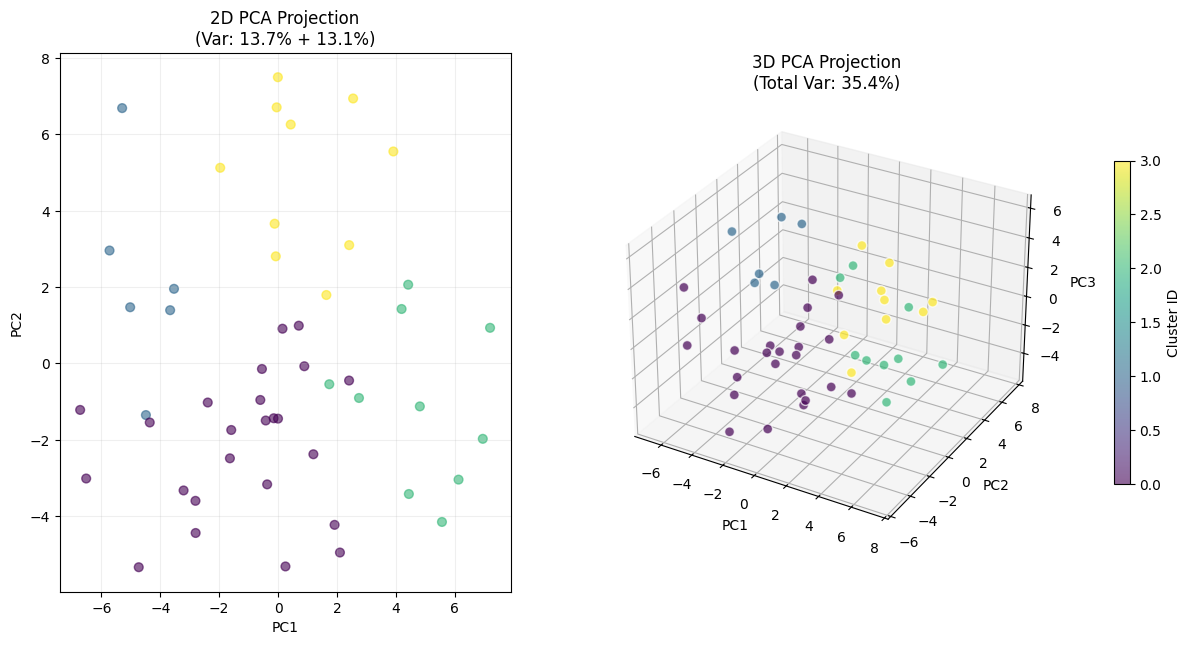

In [78]:
# 1. Extract motifs (using the function from the previous step)
# Ensure cutoff is high enough to get a good number of points (e.g., > 50 segments)
segments, meta_df, subset_indices = extract_all_motifs(
    signal_data, metadata_unique, filters, 
    m=150, channel_idx=0, n_random=200, cutoff=25.0
)

# 2. Visualize with PCA
# This will show you if the clusters actually form distinct "clouds"
clustered_meta, pca_model = cluster_and_visualize_pca_3d(segments, meta_df, n_clusters=4)



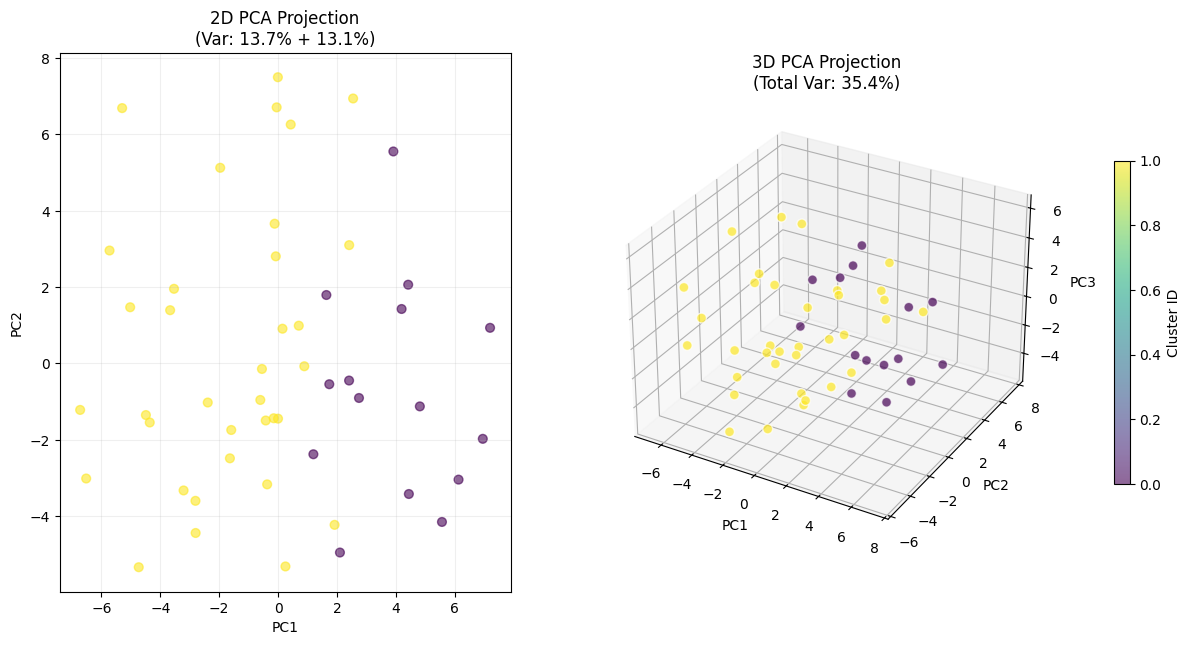

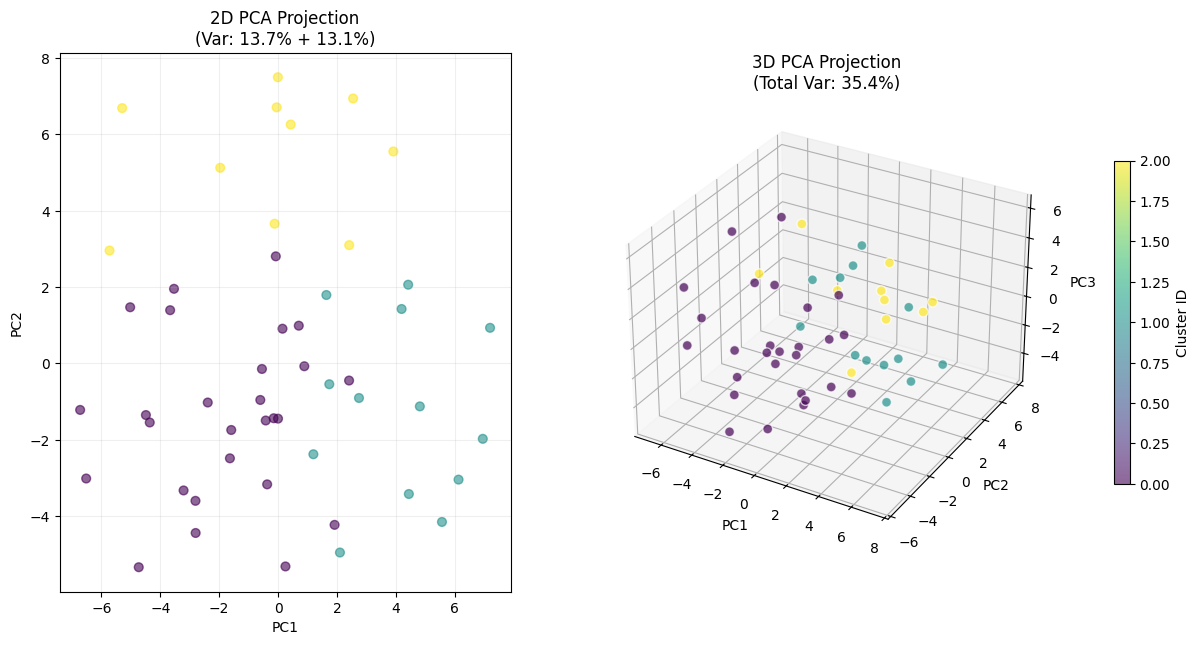

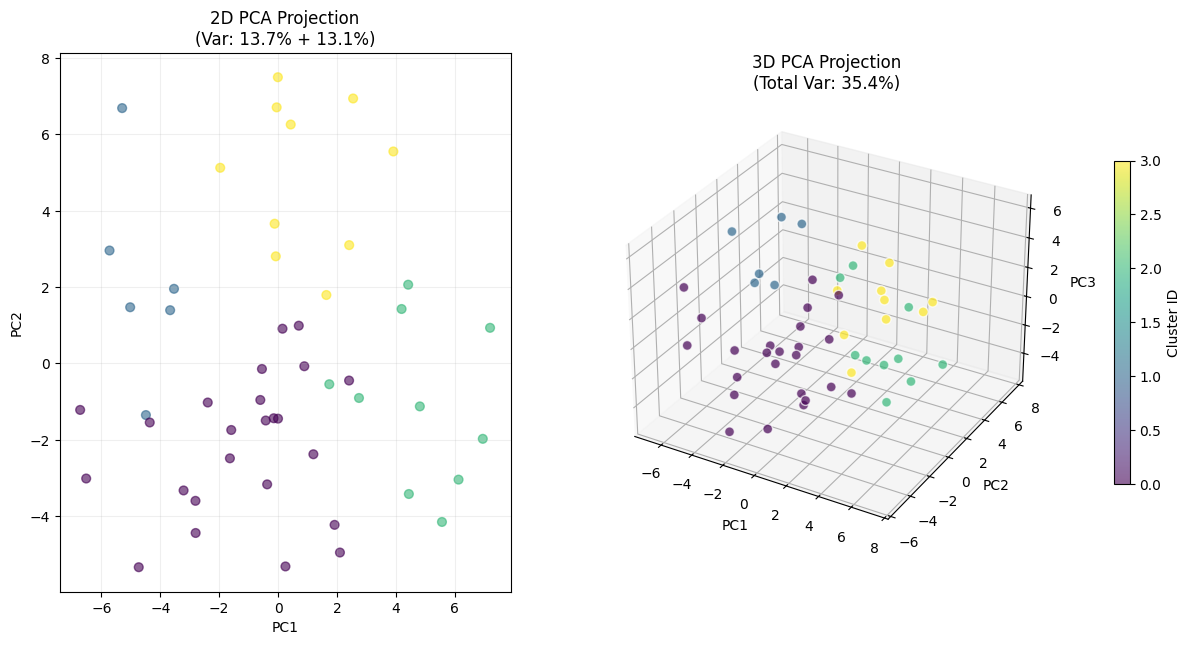

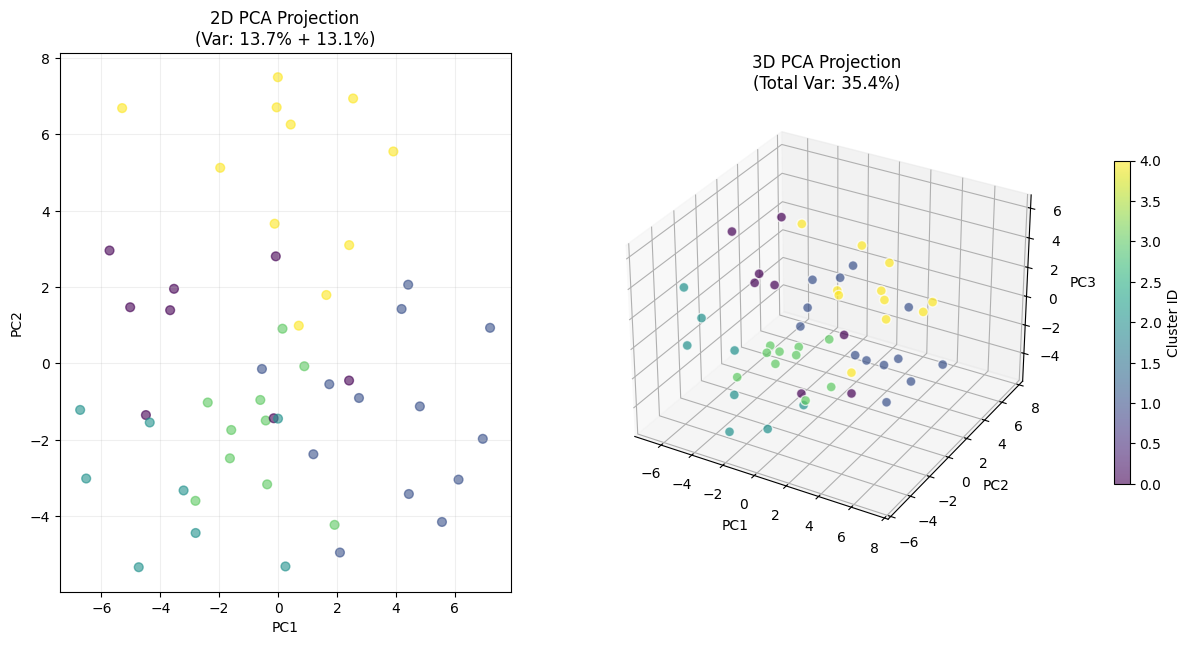

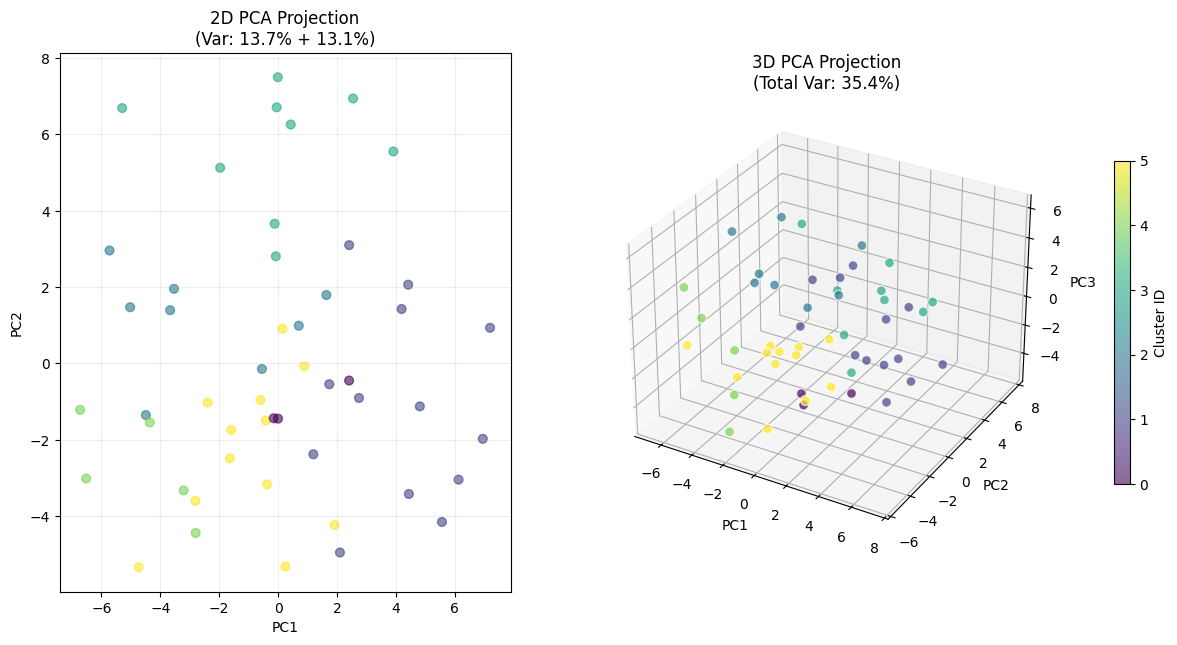

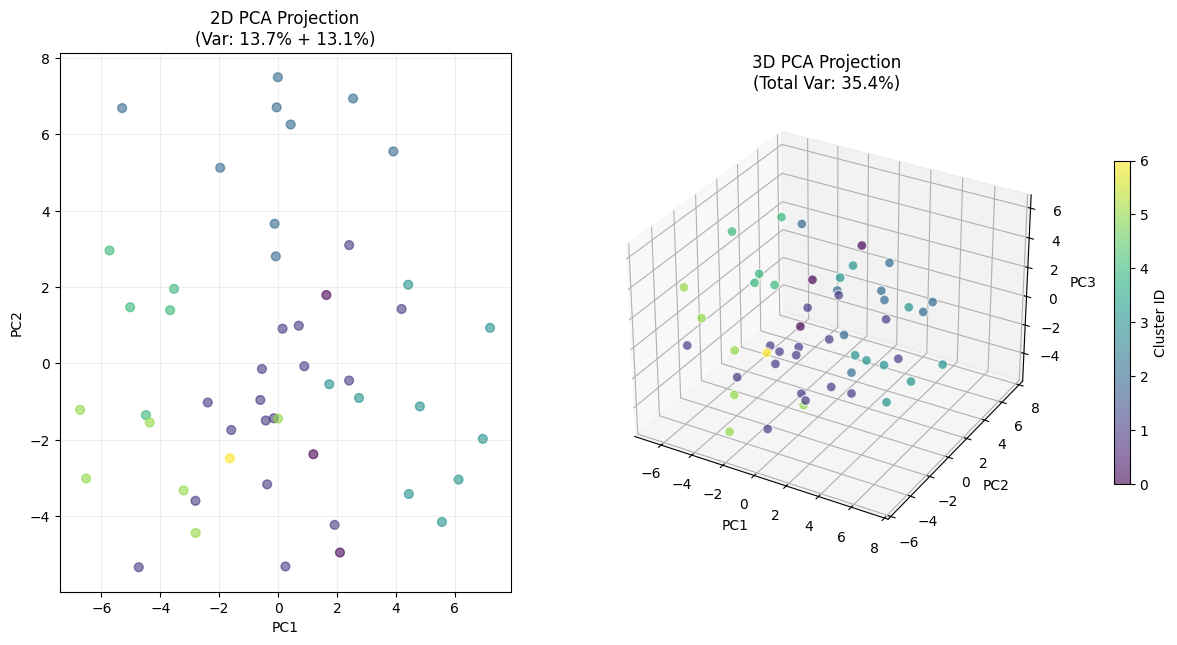

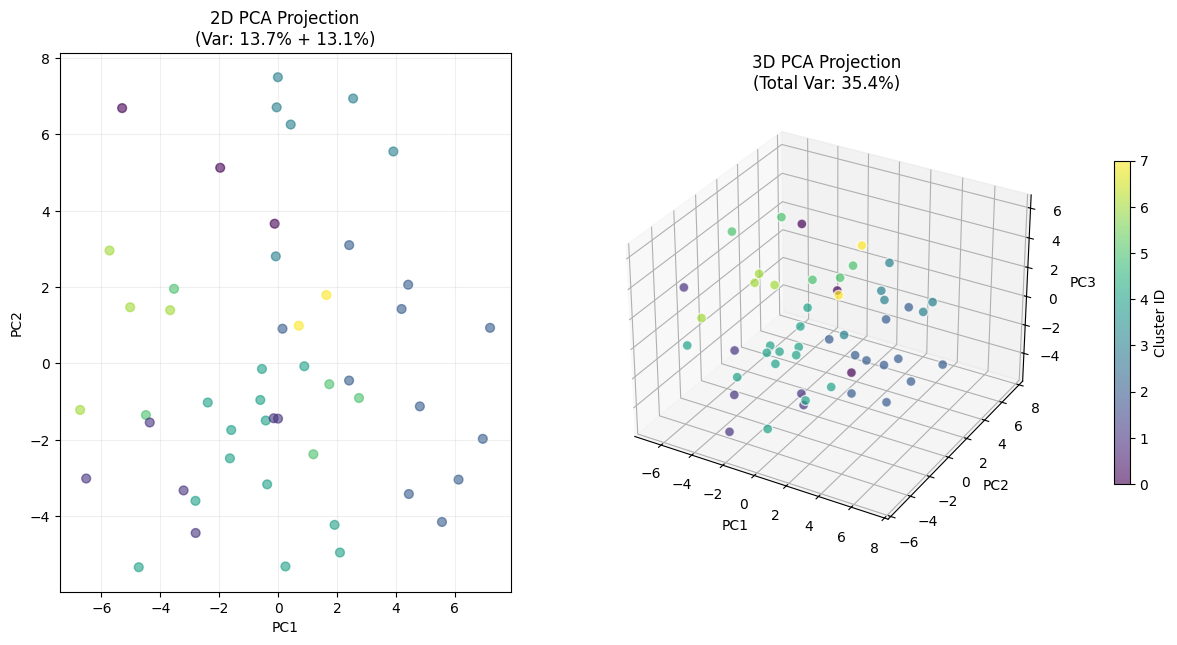

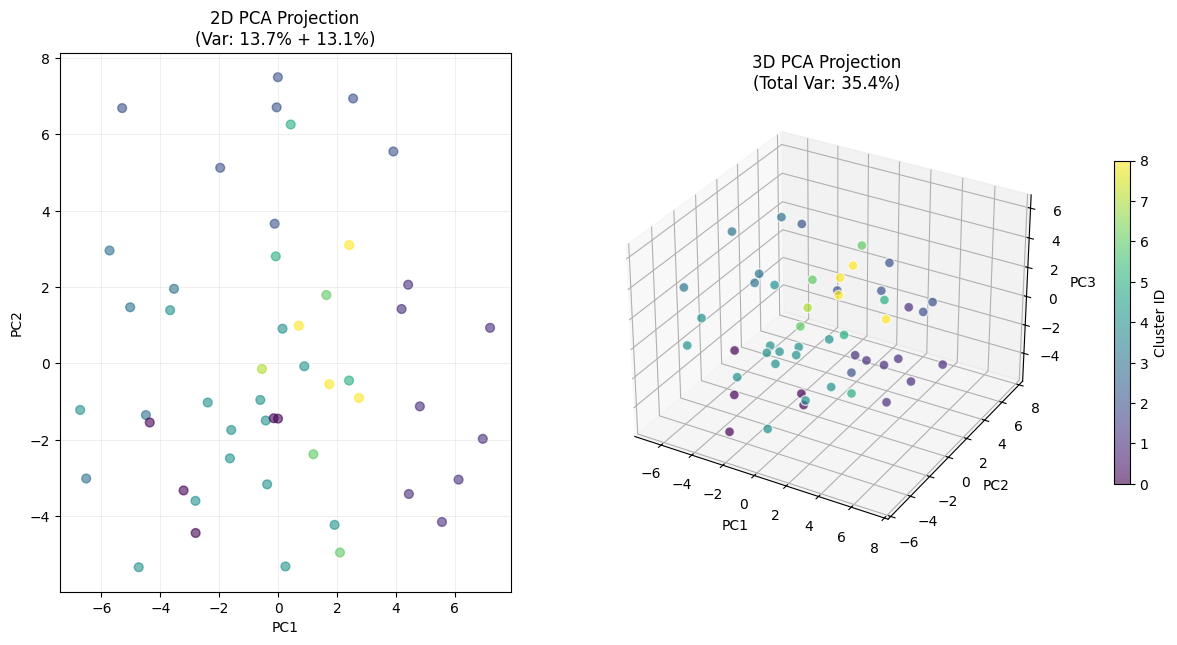

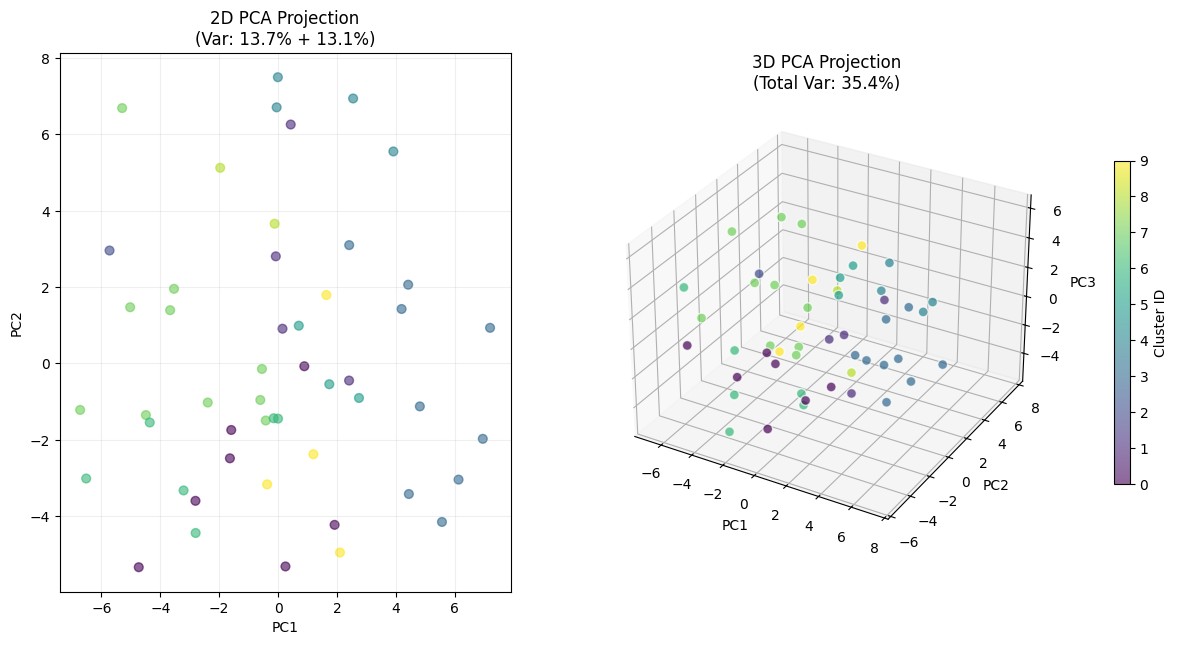

In [79]:
for c in range(2, 11):
    clustered_meta, pca_model = cluster_and_visualize_pca_3d(segments, meta_df, n_clusters=c)

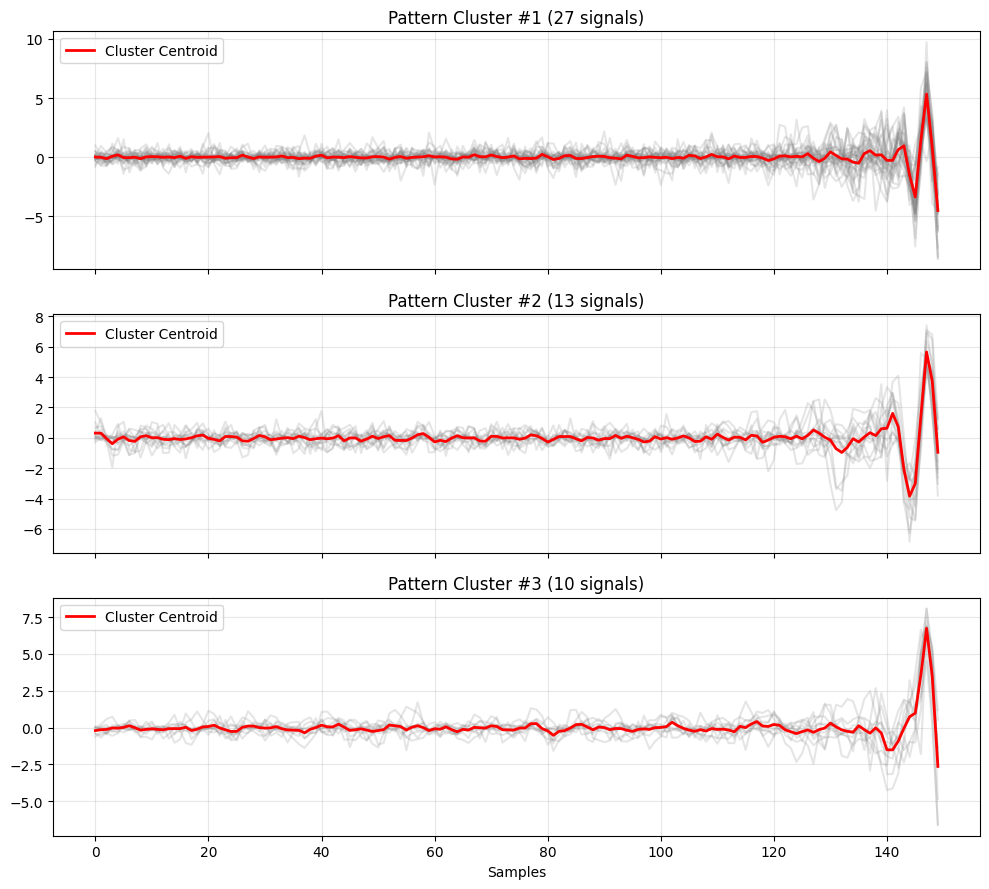

,trace_name,network_code,receiver_code,receiver_type,source_origin_time,trace_start_time,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,...,back_azimuth_deg,coda_end_sample,id,norm_s_arrival_sample,snr_db_E,snr_db_N,snr_db_V,subset_t_idx,start_offset,cluster_label
0,OKCSW.OK_20140320051240_EV,OK,OKCSW,EH,2014-03-20 05:12:23.76,2014-03-20 05:12:41.000000,35.405520,-97.438000,379.0,600.0,...,169.800,4756,1009025,414,24.900000,25.700001,19.900000,192,276,0
1,OKCSW.OK_20140224164502_EV,OK,OKCSW,EH,2014-02-24 16:44:59.73,2014-02-24 16:45:03.130000,35.405520,-97.438000,379.0,700.0,...,224.100,3199,1009004,353,29.000000,31.299999,25.900000,195,211,0
2,OHAK.AT_20130210190035_EV,AT,OHAK,BH,2013-02-10 19:00:31.63,2013-02-10 19:00:36.120000,57.222500,-153.287500,77.5,700.0,...,225.600,5900,1005195,150,69.199997,69.000000,63.400002,55,12,0
3,GNAR.NM_20130717201038_EV,NM,GNAR,HH,2013-07-17 20:10:32.88,2013-07-17 20:10:39.000000,35.965000,-90.017998,71.0,500.0,...,53.500,5900,811399,131,46.299999,50.000000,45.599998,17,2,0
4,PFVI.PM_20120603021223_EV,PM,PFVI,HH,2012-06-03 02:12:12.44,2012-06-03 02:12:24.600000,37.132832,-8.826829,189.0,800.0,...,55.100,5752,1048448,234,32.099998,25.600000,26.000000,93,106,0
5,LCO.IU_20050303041001_EV,IU,LCO,HH,2005-03-03 04:09:32.27,2005-03-03 04:10:02.760000,-29.011000,-70.700400,2300.0,800.0,...,350.300,5900,914217,561,49.200001,48.000000,44.200001,173,441,0
6,ATKA.AK_20110926200906_EV,AK,ATKA,BH,2011-09-26 20:08:47.79,2011-09-26 20:09:07.100000,52.201600,-174.197500,55.0,700.0,...,193.900,5900,268789,417,45.400002,45.799999,38.099998,83,273,0
7,BRU2.PA_20130922125010_EV,PA,BRU2,HH,2013-09-22 12:49:32.98,2013-09-22 12:50:11.530000,8.794000,-82.687800,1320.0,700.0,...,250.200,5900,577636,595,30.100000,26.600000,23.299999,46,463,0
8,RC01.AK_20031001141626_EV,AK,RC01,BH,2003-10-01 14:15:52.26,2003-10-01 14:16:27.940000,61.088900,-149.739000,390.0,600.0,...,51.800,5900,1083605,560,58.799999,58.200001,59.500000,137,415,0
9,PMR.AT_20051119011839_EV,AT,PMR,BH,2005-11-19 01:18:38.22,2005-11-19 01:18:40.040000,61.592200,-149.130800,100.0,800.0,...,78.200,5544,1054809,143,70.199997,68.900002,65.199997,1,7,2


In [80]:
cluster_and_plot_motifs(segments, meta_df, n_clusters=3)

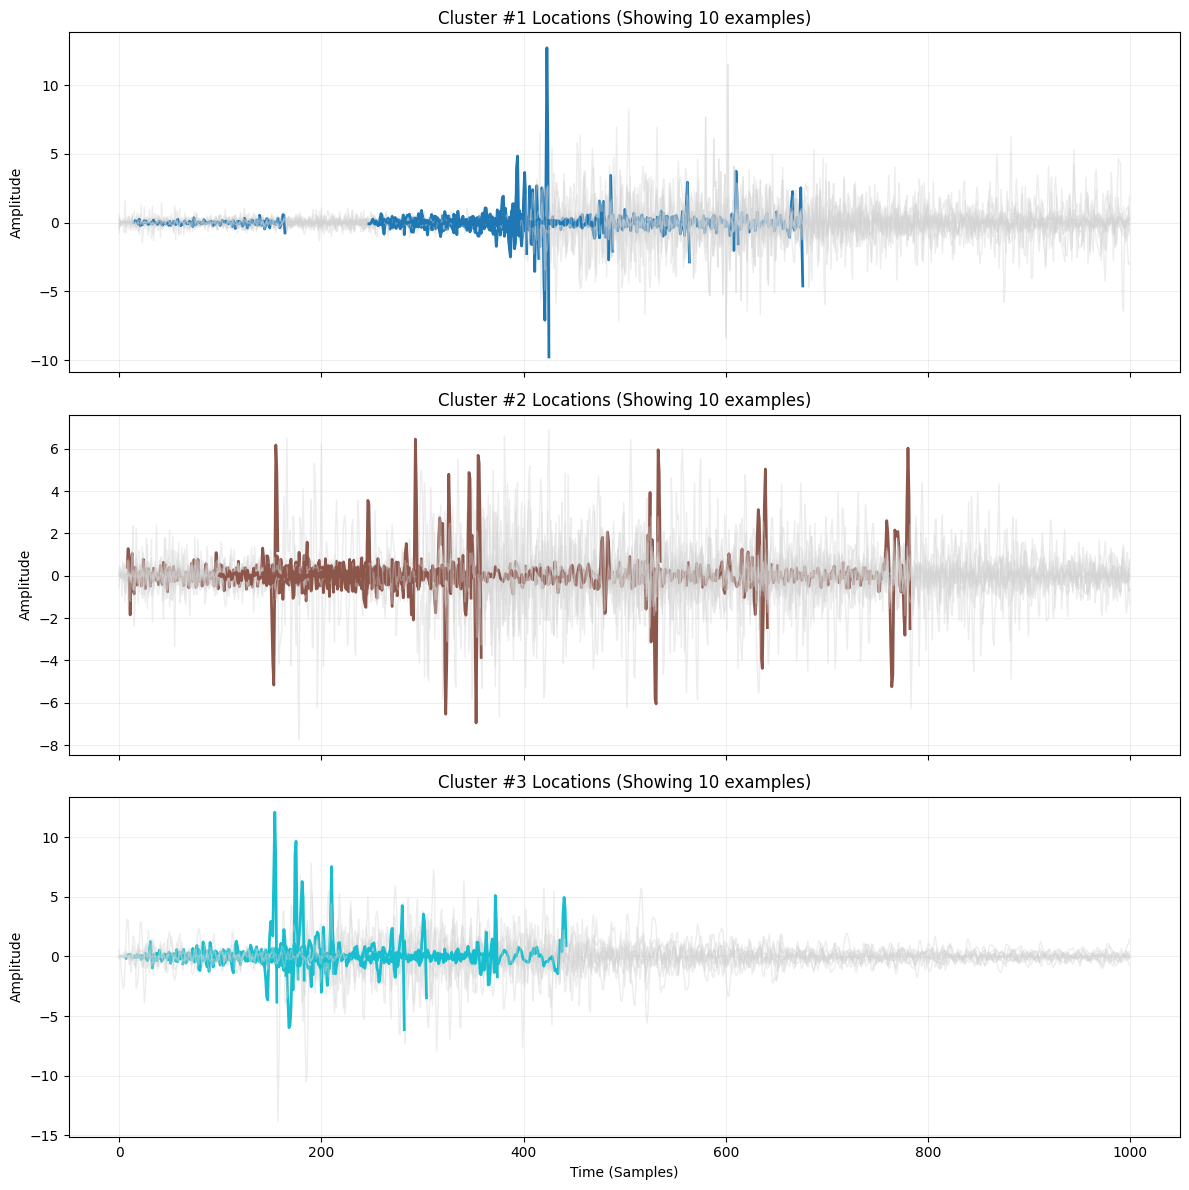

In [ ]:
clustered_meta = cluster_and_plot_full_sequences(
    segments, meta_df, signal_data, subset_indices, n_clusters=3, m=150
)

# Code Explanation

## 1. Motif Extraction

Using **multidimensional matrix profiles (mstump)**, a representative motif was extracted from every signal across all three channels. These motifs served as compressed, shape-based descriptors of the dominant local pattern within each waveform.

## 2. Automatic Cluster Selection

For each motif length, we performed a systematic evaluation of candidate cluster numbers using:

* **Within-cluster SSE (Elbow)**
* **Silhouette Score**
* **Calinski–Harabasz Index**

The optimal number of clusters was determined by combining these metrics via a median-vote heuristic.
For the 1000-step motifs, the best value converged to **k = 8 clusters**, indicating that the dataset contains approximately eight distinct characteristic waveform shapes.

## 3. Cluster Structure and Centroid Patterns

The cluster visualizations show each cluster's centroid (black curve) along with a large number of motif samples overlaid with transparency. Several strong trends emerged:

### (a) Cluster Size Variation

Clusters vary significantly in population:

* Largest clusters contain **5000–6000 signals**
* Smallest clusters contain **2500–3000 signals**

This indicates that certain motif shapes occur far more frequently in the dataset.

### (b) High Within-Cluster Agreement

Many clusters display extremely tight overlay around the centroid, especially in:

* **Channel 1** and **Channel 2**
* The **mid-segment region** (≈ 300–800)

This consistency suggests that the motifs capture a robust and repeated structural pattern in the underlying signals.

### (c) Presence of Noise-Dominated Clusters

A few clusters exhibit:

* Larger variance envelopes
* Weakly defined centroid features
* High variability in amplitude

These clusters likely correspond to **noisy signals**, **non-standard events**, or motifs that do not contain the canonical structure seen elsewhere.

### (d) Multi-Channel Synchrony

Across all clusters, the three channels tend to share:

* Similar peak timings
* Similar decay phases
* Aligned transient features

This validates that the motifs are capturing a **coherent multivariate event** rather than unrelated channel-specific fluctuations.

### (e) Distinctive Onset Characteristics

The main differences between clusters arise from:

* Amplitude and sign of the initial transient (first ~150 samples)
* Strength of the peak around the motif center (~400–600 samples)
* Noise level and decay slope in the final third

These distinctions allow the clustering to separate signals not only by shape but also by subtle temporal dynamics.

## 4. PCA Visualization

PCA 2D and 3D projections show clearly separable cluster groups.
Most clusters form well-bounded ellipsoidal clouds, supporting that:

* The centroid shapes represent **distinct waveform families**

Some overlaps occur between noise-heavy clusters, consistent with the less defined centroid structures observed.



# Results

- We applied multidimensional motif discovery and clustering to a dataset of **three-channel seismic signals** using motif lengths of 100, 200, 500, and 1000 time steps.

## m=100
- For m=100, the motifs we're not significant. This is expected since m=100 is insufficient for capturing a global pattern among all the series.
- Also the cluster centroids are not too descriptive, they correspond to flat lines.

## m=200
- Same situation with m=100 happens again with m=200. The clusters do not distribute evenly and cluster centroids do not show a significant pattern.

## m=500

- Our algorithm which runs via Elbow method has extracted two clusters. Cluster 0 shows a magnitude flow similar to negative log(x) plot. This cluster represents the %12 of our signals. It shows a noisy yet descriptive shapelet.

- Cluster 1 contains the rest. Since these signals could not be seperated into more clusters, this cluster shows a noisy behaviour. This unfortunately is not informative in our analysis.

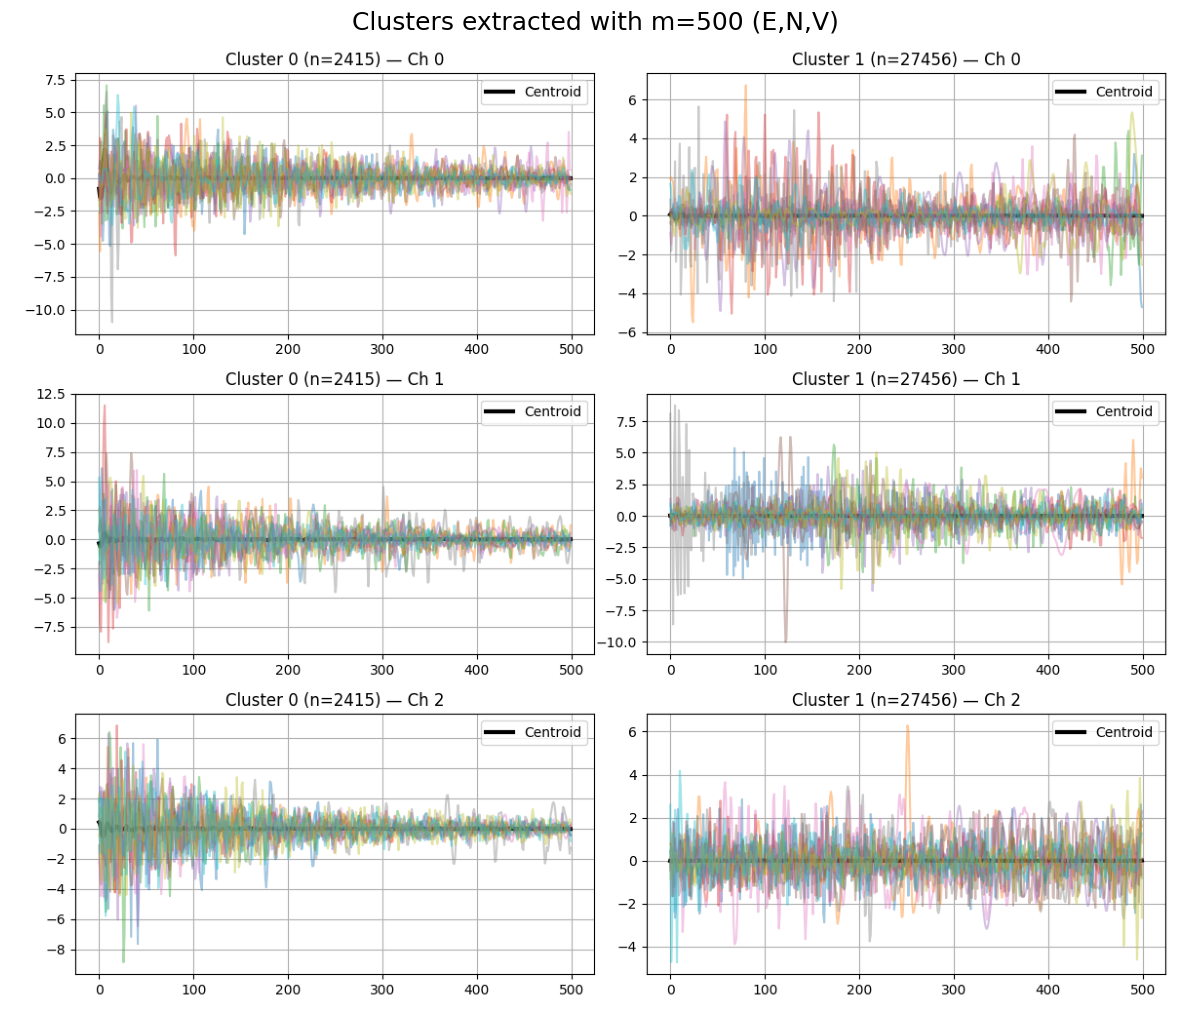

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img_E = mpimg.imread("motif_results_stumpy\m_500\clusters_m500.png")


# Plot BIG images with colorful colormap
plt.figure(figsize=(12, 12))

plt.imshow(img_E)
plt.title("Clusters extracted with m=500 (E,N,V)", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()


## m=1000

- This experiment is the most informative one ever conducted in terms of this work.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img_E = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-E_channel_0.png")
img_N = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-N_channel_1.png")
img_V = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-V_channel_2.png")

# Plot BIG images with colorful colormap
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.imshow(img_E)
plt.title("Channel E", fontsize=18)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(img_N)
plt.title("Channel N", fontsize=18)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(img_V)
plt.title("Channel V", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()


 The results reported here focus on the **1000-length motifs**, which produced the most stable and interpretable cluster structures.